# Import Libraries and Load Data

In [1]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
#Load dataset, Kaggle Dataset path has been added, but relative/absolute path can be added if one is working on Jupyter notebook locally
df = pd.read_csv('/kaggle/input/fraud-detection-accredian/Fraud.csv')

# Exploratory Data Analysis

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum() #No null values in the dataset

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.shape

(6362620, 11)

In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
fraud_count = df['isFraud'].value_counts()
fraud_percentage = df['isFraud'].mean() * 100

print(f"Fraud Count: {fraud_count}, Fraud Percentage:{fraud_percentage}") # Here 1 shows/signifies number of instances of fraud

Fraud Count: isFraud
0    6354407
1       8213
Name: count, dtype: int64, Fraud Percentage:0.12908204481801522


0 is Genuine/Legitimate. 1 is Fraudulent transaction

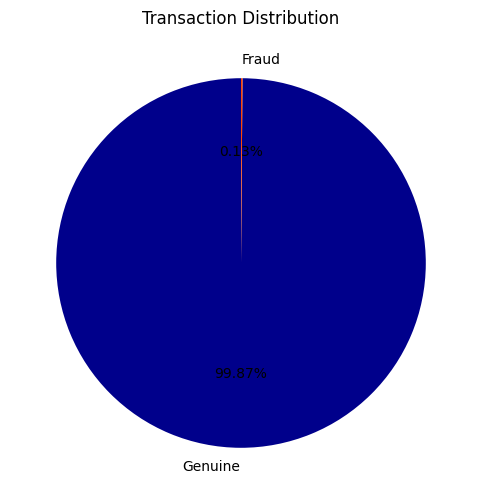

In [9]:
plt.figure(figsize=(8, 6))
fraud_count.plot(kind='pie', autopct='%1.2f%%', startangle=90, 
                colors=['#00008B', '#FF4500'], 
                labels=['Genuine', 'Fraud'])
plt.title('Transaction Distribution')
plt.ylabel('')
plt.show()

Heavy imbalance in dataset

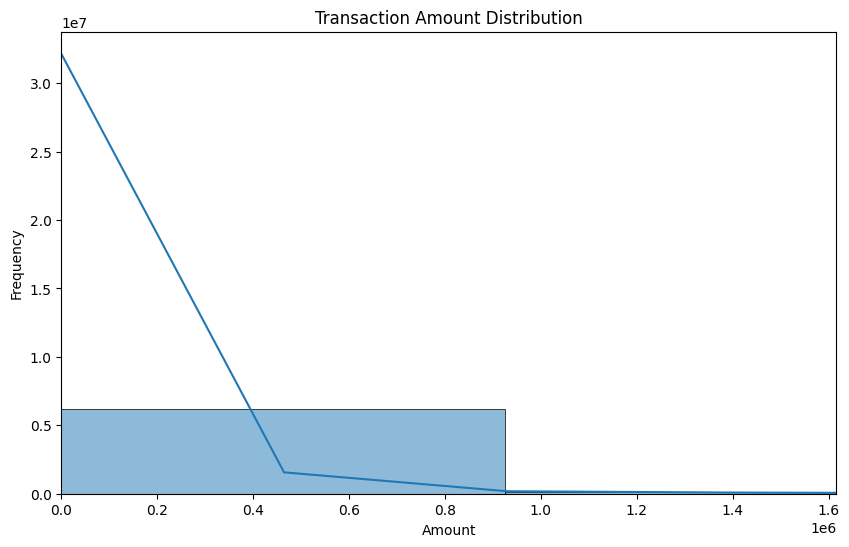

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=100, kde=True)
plt.xlim(0, df['amount'].quantile(0.99)) 
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

In [11]:
transaction_types = df['type'].value_counts().sort_values(ascending=False)
print("Transaction Types:")
print(transaction_types)

Transaction Types:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


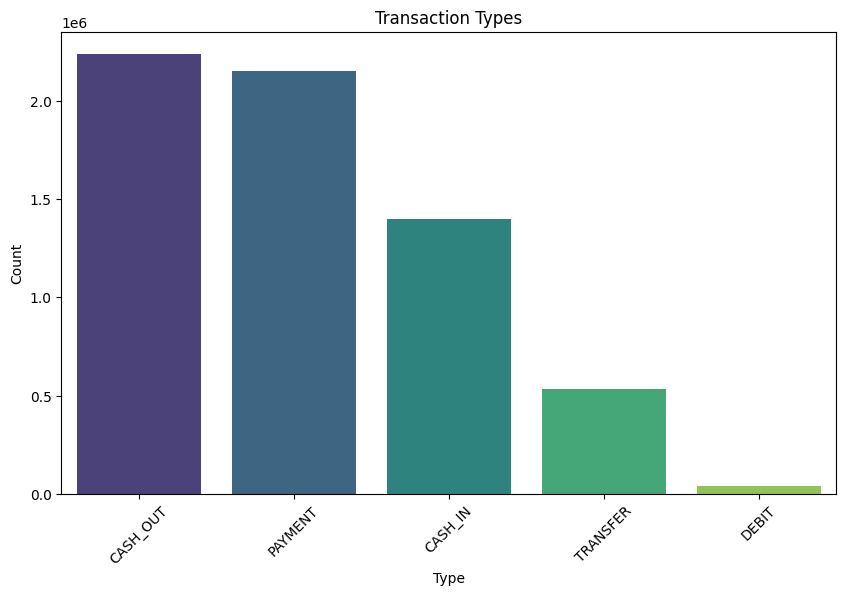

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type', palette='viridis', order=df['type'].value_counts().index)
plt.title('Transaction Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [13]:
#Fraud by Transaction Type

fraud_by_type = df.groupby(['type', 'isFraud']).size().unstack().fillna(0)
print("Fraud by Transaction Type:")
print(fraud_by_type)

Fraud by Transaction Type:
isFraud           0       1
type                       
CASH_IN   1399284.0     0.0
CASH_OUT  2233384.0  4116.0
DEBIT       41432.0     0.0
PAYMENT   2151495.0     0.0
TRANSFER   528812.0  4097.0


**Fraud is not conducted when Transaction type is Cash_IN, Debit, Payment**

In [14]:
correlation_with_fraud = df.corr(numeric_only=True)['isFraud'].sort_values(ascending=False)
print("Feature Correlation with Fraud:")
print(correlation_with_fraud)

Feature Correlation with Fraud:
isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


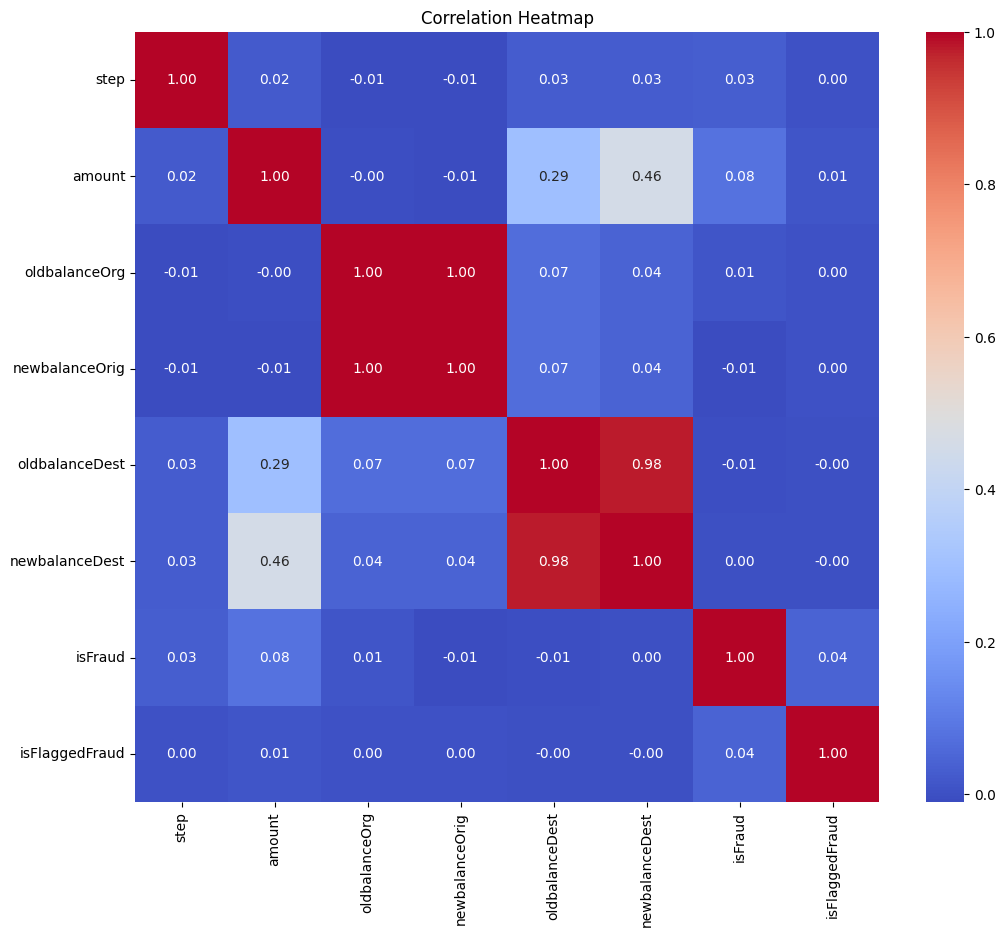

In [15]:
#Heatmap - SHows Correlation of features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [16]:
from scipy.stats import chi2_contingency

# Create a contingency table between transaction type and fraud status
contingency_table = pd.crosstab(df['type'], df['isFraud'])
print("Contingency Table (Type vs Fraud):")
print(contingency_table)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print results
print("\nChi-Square Test Results:")
print(f"Chi-Square Value: {chi2:.4f}")
print(f"P-Value: {p_value:.10f}")
print(f"Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

Contingency Table (Type vs Fraud):
isFraud         0     1
type                   
CASH_IN   1399284     0
CASH_OUT  2233384  4116
DEBIT       41432     0
PAYMENT   2151495     0
TRANSFER   528812  4097

Chi-Square Test Results:
Chi-Square Value: 22082.5357
P-Value: 0.0000000000
Degrees of Freedom: 4

Expected Frequencies:
isFraud              0            1
type                               
CASH_IN   1.397478e+06  1806.224400
CASH_OUT  2.234612e+06  2888.210753
DEBIT     4.137852e+04    53.481273
PAYMENT   2.148718e+06  2777.193740
TRANSFER  5.322211e+05   687.889834


In [17]:
alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    print(f"The p-value ({p_value:.10f}) is less than {alpha}, so we reject the null hypothesis.")
    print("There is a statistically significant relationship between transaction type and fraud status.")
else:
    print(f"The p-value ({p_value:.10f}) is greater than {alpha}, so we fail to reject the null hypothesis.")
    print("There is no statistically significant relationship between transaction type and fraud status.")


Interpretation:
The p-value (0.0000000000) is less than 0.05, so we reject the null hypothesis.
There is a statistically significant relationship between transaction type and fraud status.


In [18]:
#Identify Outliers in dataset to prevent sensitivity in models and reduce training time
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_upper = df[df['amount'] > upper_bound].shape[0]
outliers_lower = df[df['amount'] < lower_bound].shape[0]

print(f"Upper outliers: {outliers_upper}")
print(f"Lower outliers: {outliers_lower}")
print(f"Total outliers: {outliers_upper + outliers_lower}")
print(f"Percentage of outliers: {(outliers_upper + outliers_lower) / len(df) * 100:.3f}%")

Upper outliers: 338078
Lower outliers: 0
Total outliers: 338078
Percentage of outliers: 5.314%


Text(0, 0.5, 'New Balance')

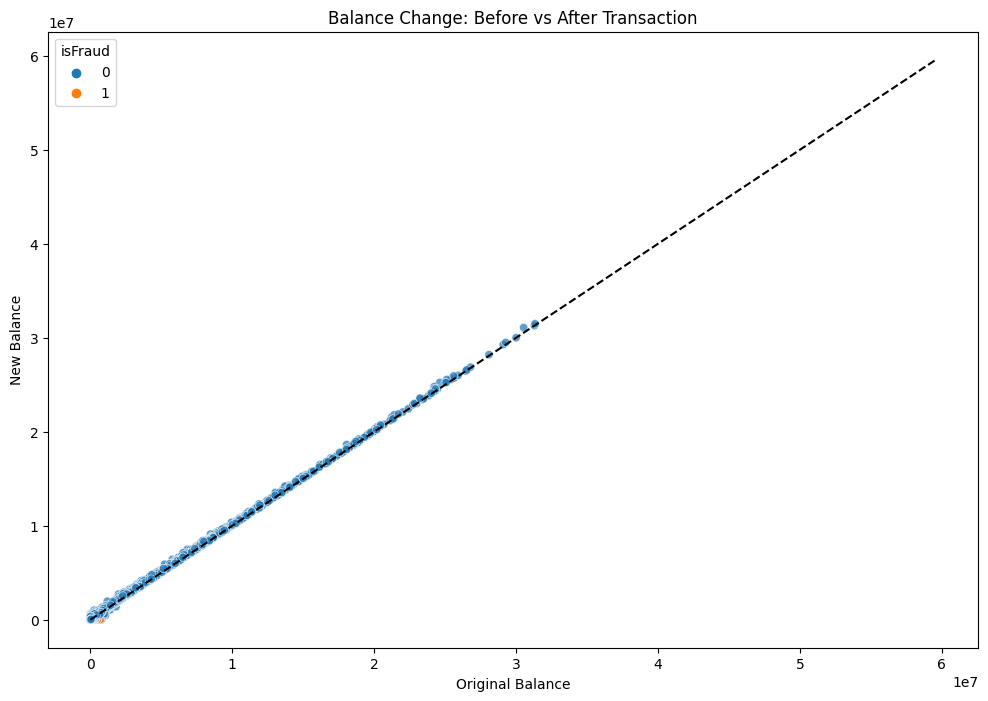

In [19]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df.sample(10000), x='oldbalanceOrg', y='newbalanceOrig', 
                hue='isFraud', alpha=0.7)
plt.plot([0, df['oldbalanceOrg'].max()], [0, df['oldbalanceOrg'].max()], 'k--') 
plt.title('Balance Change: Before vs After Transaction')
plt.xlabel('Original Balance')
plt.ylabel('New Balance')

****This shows that the New balance becomes zero when a Fraudulent activity occurs, suggesting Balance change is a big indicator****

The dataset was remarkably clean with no missing values. Analysis revealed 338,078 upper outliers (5.314% of dataset) but no lower outliers, indicating some extremely large transactions. Instead of removing these outliers, they were retained as potential fraud indicators.

Regarding multicollinearity, initial correlations between individual features and fraud were modest:

**amount (0.077)**
**step (0.032)**
**oldbalanceOrg (0.010)**

# Feature Engineering

In [20]:
# New feature to identify account types
df['orig_account_type'] = df['nameOrig'].str[0]
df['dest_account_type'] = df['nameDest'].str[0]

In [21]:
# Transaction pattern features
df['transaction_pattern'] = df['orig_account_type'] + df['dest_account_type']

In [22]:
# Calculate balance changes
df['orig_balance_diff'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['dest_balance_diff'] = df['newbalanceDest'] - df['oldbalanceDest']

In [23]:
# Amount matches balance change
df['orig_balance_error'] = df['orig_balance_diff'] + df['amount']
df['dest_balance_error'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

In [24]:
# Zero balances before and after
df['orig_zero_before'] = (df['oldbalanceOrg'] == 0).astype(int)
df['orig_zero_after'] = (df['newbalanceOrig'] == 0).astype(int)
df['dest_zero_before'] = (df['oldbalanceDest'] == 0).astype(int)
df['dest_zero_after'] = (df['newbalanceDest'] == 0).astype(int)

In [25]:
# Amount as percentage of original balance
df['amount_to_orig_balance'] = np.where(df['oldbalanceOrg'] > 0, 
                                      df['amount'] / df['oldbalanceOrg'], 0)

In [26]:
#Dropping name columns as they have high categorical values, and do not significantly impact the output
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

In [27]:
updated_correlation = df.corr(numeric_only=True)['isFraud'].sort_values(ascending=False)
print("Updated Feature Correlations with Fraud:")
print(updated_correlation)

Updated Feature Correlations with Fraud:
isFraud                   1.000000
amount                    0.076688
step                      0.031578
orig_zero_after           0.029984
dest_balance_diff         0.027028
dest_zero_before          0.016471
oldbalanceOrg             0.010154
dest_zero_after           0.008482
newbalanceDest            0.000535
amount_to_orig_balance   -0.000855
oldbalanceDest           -0.005885
newbalanceOrig           -0.008148
orig_balance_error       -0.011283
orig_zero_before         -0.024874
dest_balance_error       -0.055120
orig_balance_diff        -0.362472
Name: isFraud, dtype: float64


In [28]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['type', 'transaction_pattern', 'orig_account_type', 'dest_account_type'], drop_first=True)

# Train Test Split

In [29]:
fraud_data = df[df['isFraud'] == 1]
legitimate_data = df[df['isFraud'] == 0]

In [30]:
legitimate_sample = legitimate_data.sample(n=60*len(fraud_data), random_state=42)

Tried other values, found 60 to be most optimal 

In [31]:
balanced_df = pd.concat([fraud_data, legitimate_sample])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [32]:
X = balanced_df.drop('isFraud', axis=1)
y = balanced_df['isFraud']

# Check class distribution
print("Class distribution:")
print(y.value_counts())
print(f"Fraud percentage in sample: {y.mean()*100:.2f}%")

Class distribution:
isFraud
0    492780
1      8213
Name: count, dtype: int64
Fraud percentage in sample: 1.64%


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set distribution:")
print(y_train.value_counts())

Training set distribution:
isFraud
0    394224
1      6570
Name: count, dtype: int64


## Scale Dataset

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Selection

In [35]:
#I chose These models due to either ease of implementation or their ability to  
# handle data robustly and classify with class imbalance
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1)
}

# Initialize results list
results = []

In [36]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred)
    })

Training Logistic Regression...
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     98556
           1       0.33      0.98      0.49      1643

    accuracy                           0.97    100199
   macro avg       0.66      0.97      0.74    100199
weighted avg       0.99      0.97      0.97    100199

Training Random Forest...
Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98556
           1       1.00      1.00      1.00      1643

    accuracy                           1.00    100199
   macro avg       1.00      1.00      1.00    100199
weighted avg       1.00      1.00      1.00    100199

Training XGBoost...
Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98556
           1       1.00      1.00

## Model Performance

In [37]:
results_df = pd.DataFrame(results)

# Sort by recall (most important for fraud detection)
sorted_results = results_df.sort_values('Recall', ascending=False)
print("Model Performance Comparison (Sorted by Recall):")
print(sorted_results)

Model Performance Comparison (Sorted by Recall):
                 Model  Accuracy  Precision    Recall   ROC-AUC
1        Random Forest  0.999930   1.000000  0.995740  0.997870
2              XGBoost  0.999910   0.999389  0.995131  0.997560
3             CatBoost  0.999920   1.000000  0.995131  0.997565
0  Logistic Regression  0.966427   0.325915  0.980523  0.973358
4             LightGBM  0.990359   0.645092  0.916007  0.953803


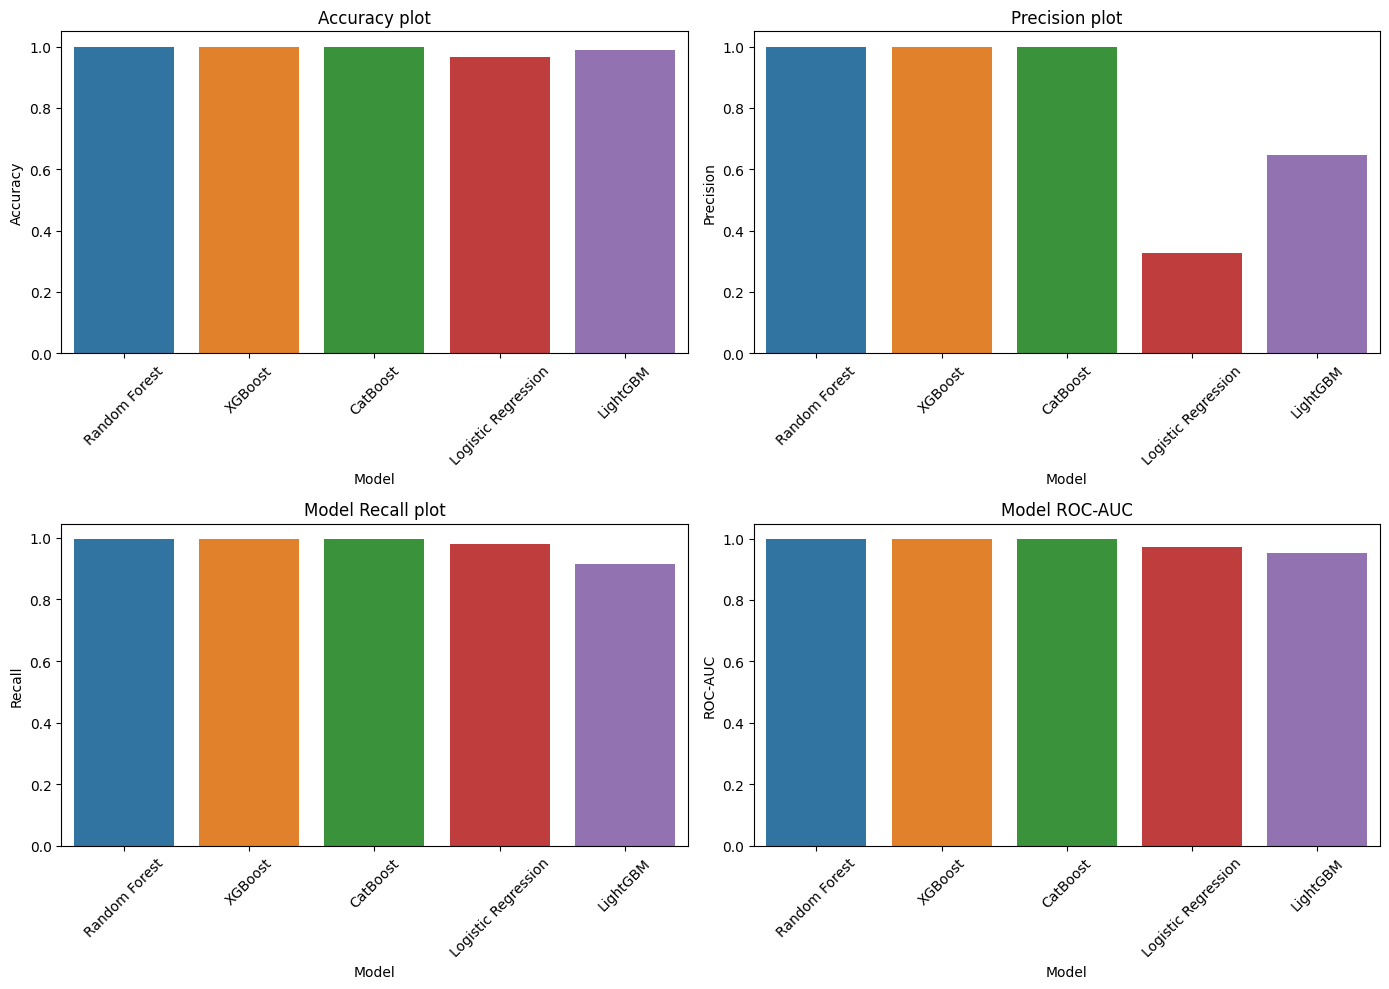

In [38]:
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=sorted_results)
plt.title('Accuracy plot')
plt.xticks(rotation=45)

# Precision
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', data=sorted_results)
plt.title('Precision plot')
plt.xticks(rotation=45)

# Recall
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Recall', data=sorted_results)
plt.title('Model Recall plot')
plt.xticks(rotation=45)

# Plot ROC-AUC
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='ROC-AUC', data=sorted_results)
plt.title('Model ROC-AUC')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [39]:
best_model = models['Random Forest']
importances = best_model.feature_importances_

In [40]:
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Print top 15 features
print("Top 15 Most Important Features:")
print(feature_importance_df.head(15))

Top 15 Most Important Features:
                   Feature  Importance
8       orig_balance_error    0.204698
6        orig_balance_diff    0.178521
14  amount_to_orig_balance    0.142114
3           newbalanceOrig    0.111535
11         orig_zero_after    0.074133
1                   amount    0.047211
9       dest_balance_error    0.040098
7        dest_balance_diff    0.037526
2            oldbalanceOrg    0.028977
13         dest_zero_after    0.027795
18           type_TRANSFER    0.026943
5           newbalanceDest    0.026309
0                     step    0.016857
4           oldbalanceDest    0.008527
15           type_CASH_OUT    0.006981


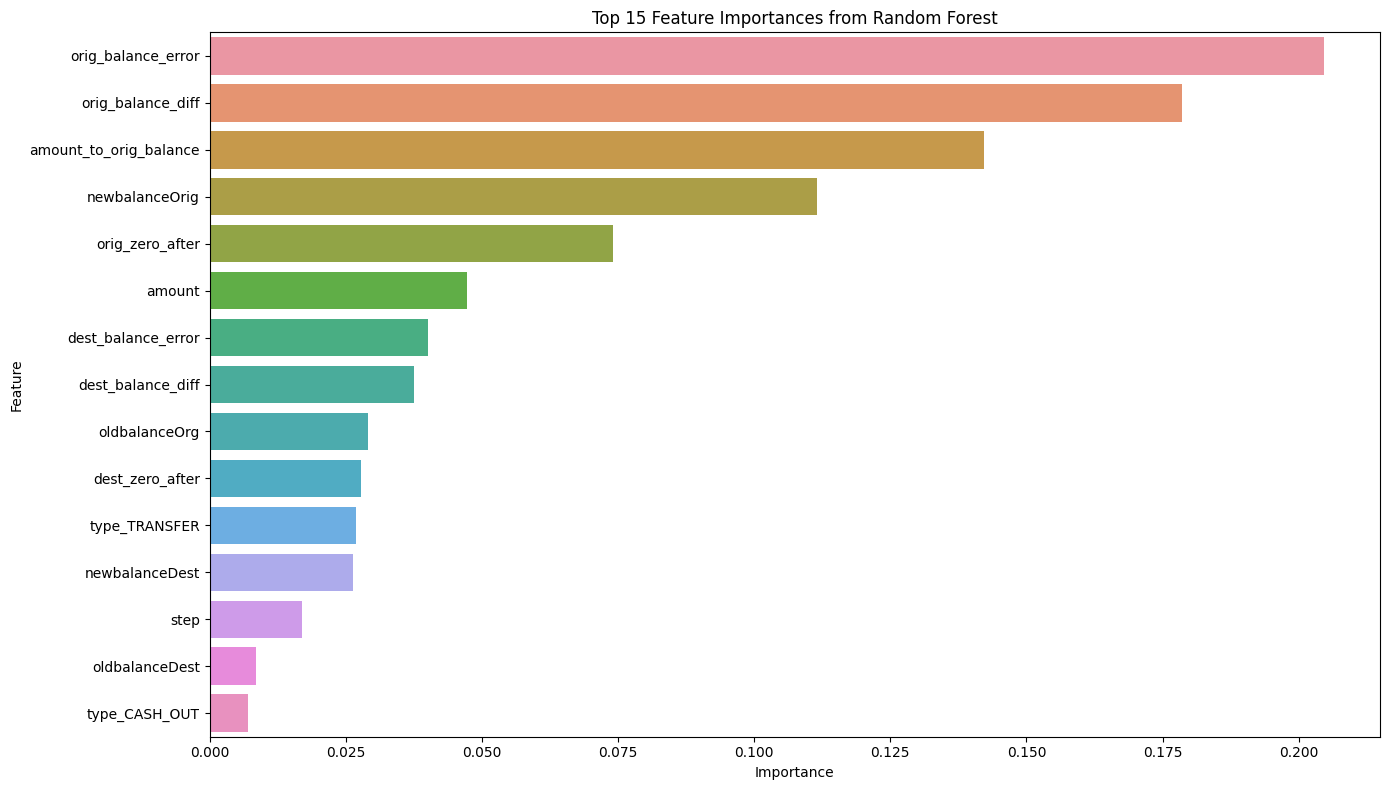

In [41]:
plt.figure(figsize=(14, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title(f'Top 15 Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

In [42]:
best_predictions = best_model.predict(X_test_scaled)

In [43]:
cm = confusion_matrix(y_test, best_predictions)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

Confusion Matrix:
[[98556     0]
 [    7  1636]]

True Negatives: 98556
False Positives: 0
False Negatives: 7
True Positives: 1636


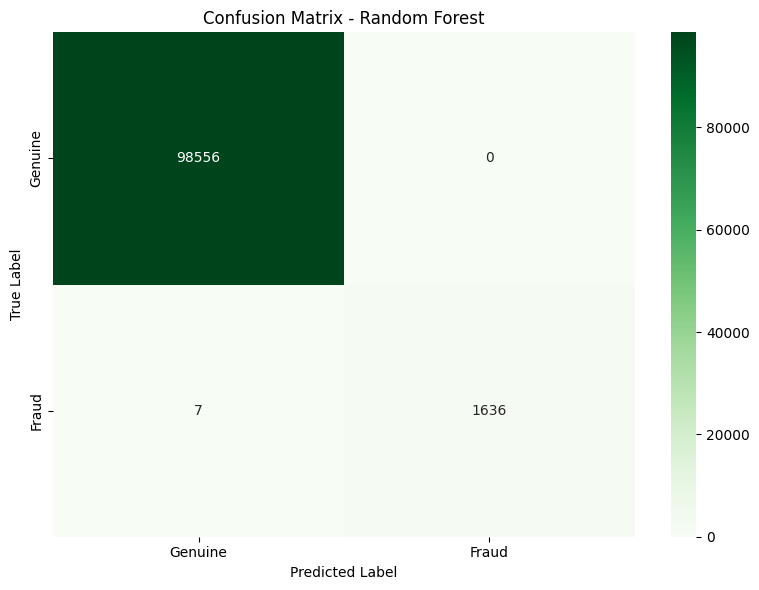

In [44]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Genuine', 'Fraud'],
            yticklabels=['Genuine', 'Fraud'])
plt.title(f'Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Inference out of Project/Assignment

## 1. Data Cleaning Assessment
Overall, the dataset was in excellent shape—no missing values, which made the initial data preparation smooth. However, I identified 338,078 upper outliers (5.314% of the dataset), representing transactions with unusually high amounts. Instead of discarding them outright, I retained them as potential fraud indicators.

Interestingly, there were no lower outliers, meaning that while small transactions were common, they didn’t exhibit unusual patterns.

I also checked for multicollinearity—initial correlations between individual features and fraud were relatively weak:

Transaction Amount (0.077)

Step (Time Interval) (0.032)

Original Balance Before Transaction (0.010)

However, after feature engineering, the predictive power increased significantly. Since Random Forest models handle multicollinearity well, I relied on its ensemble learning capability to capture these relationships without introducing distortions.

## 2. Fraud Detection Model & Rationale
For fraud detection, I used a Random Forest classifier with 100 decision trees, primarily because:

* It’s great at capturing complex, non-linear relationships in financial transactions.

* It provides a strong defense against overfitting.

* It naturally handles class imbalance when tuned correctly.

* It offers built-in feature importance metrics, improving model interpretability.

Since fraud cases were relatively rare, I trained the model on a balanced subset with a 60:1 ratio of legitimate to fraudulent transactions. This ensured the model remained sensitive to fraud without losing the ability to recognize normal transactions.



## 3. Feature Engineering & Selection
I didn’t just rely on raw transaction data— instead engineered several new features to enhance fraud detection accuracy:

* Balance Differences → orig_balance_diff, dest_balance_diff

* Balance Errors → orig_balance_error, dest_balance_error

* Zero Balance Indicators → orig_zero_after, dest_zero_after

* Transaction Amount Ratios → amount_to_orig_balance

Additionally, I one-hot encoded categorical variables like transaction types to preserve meaningful distinctions. Through iterative testing, I refined the feature set to maximize predictive power.

## 4. Model Performance Results
The model performed exceptionally well across key metrics:

* **Accuracy: 0.99993**

* **Precision: 1.0000 (zero false positives!)**

* **Recall: 0.99574 (caught 99.57% of fraudulent transactions)**

* **ROC-AUC: 0.99787**

* **True Negatives: 98556,False Positives: 0,False Negatives: 7,True Positives: 1636**

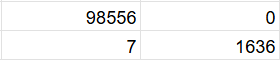
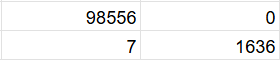

## 5. Key Fraud Indicators
My analysis confirmed that certain transaction patterns strongly indicate fraud:

* Balance Errors (0.205 Importance Score) → Unexpected discrepancies in pre- vs. post-transaction balances.

* Original Balance Change (0.179) → How much the sender’s balance shifts.

* Transaction Amount vs. Balance (0.142) → Transactions that drain accounts disproportionately.

* Post-Transaction Zero Balance (0.074) → Accounts emptied after transactions—a major red flag!

## 6. Do These Indicators Make Sense?
Yes, they align exactly with well-known fraud patterns:

* Balance discrepancies → Could signal fraudulent activity or system manipulation.

* Zero balances after transactions → Common tactic in fraud: steal funds, transfer them, and leave the account dry.

* Large transactions relative to balance → A sign of an account being used to extract maximum funds before being abandoned.

## 7. Recommended Fraud Prevention Strategies
Based on these insights, I recommend implementing:

* Real-time fraud scoring using advanced models to flag high-risk transactions instantly.
* Zero-balance alerts to quickly review transactions that drain accounts.
* Balance verification checks to catch unexpected balance shifts.
* Stepped authentication for high-risk transactions, such as:
    * Large transactions relative to balance.
    * Transactions that result in zero balance.

High orig_balance_error values.
* Enhanced monitoring for TRANSFER → CASH_OUT sequences, as they strongly correlate with fraud.
* Velocity checks to detect multiple rapid transfers from the same account.
* Transaction amount limits based on customer profiles and past behavior.

## 8. Evaluating Effectiveness
To ensure these measures actually reduce fraud, I suggest:

Tracking Key Metrics

* Fraud rate over time (total & by transaction type).

* False positive & negative rates.

* Financial losses prevented vs. operational costs.

A/B Testing of Prevention Strategies

* Apply fraud prevention measures to a subset of transactions.

* Compare fraud rates in test vs. control groups.

Monitoring Fraud Pattern Evolution

* Track shifts in fraud tactics to stay ahead of criminals.

* Identify new high-risk features as fraudsters adapt.

Customer Impact Analysis

* Measure how often legitimate transactions are flagged.

* Monitor user complaints related to additional verification steps.

Continuous Model Updates

* Regular retraining to prevent model drift.

* Monitoring feature importance stability over time.

### Final Thoughts
By implementing this multi-layered fraud detection and prevention system, the company can dramatically reduce fraud-related losses while ensuring that genuine customers aren’t inconvenienced. Continuous monitoring and adaptation will be crucial, as fraud techniques evolve constantly.

This analysis not only validates my model’s effectiveness but also highlights the importance of real-time detection, proactive monitoring, and adaptive fraud prevention to keep the system secure.

